<a href="https://colab.research.google.com/github/jieunjeon/Data-Science-Fundamental/blob/master/Exploration/%5BE_10%5D_Text_Summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal of this project
1. Understanding Extractive/Abstractive summarization
2. Try various text normalizations that reduce the size of the vocabulary
3. Applying Attention Mechanism that improves the performance of seq2seq

# Dataset
Kaggle's **Amazon Review Dataset**
https://www.kaggle.com/bittlingmayer/amazonreviews

# Table of Contents
0. seq2seq2 Concept Review
1. Load the Data
2. Data Preprocessing
3. Encoding
4. Create Model
5. Attention Mechanism (Extractive summarization)
6. Train the Model
7. Compare the result and the summary
8. Test the Model
9. Try library Summa


# 0. seq2seq2 Concept Review

## seq2seq ?
1. We will use LSTM (RNN) so cell state with the hidden state must be used.
2. The decoder's prediction sequence is prefixed with a start token SOS and a prediction token EOS attached to the back of the sequence.
3. When running `seq2seq`, the decoder receives a start token and starts prediction.
4. Unlike the `seq2seq` basic model, the `context vector` that collects the importance of the encoder's hidden state is calculated for each decoder step using the attention mechanism.
5. Using the computed context vector, the `decoder` predicts the next occurrence of the word.

## seq2seq - Encoder and Decoder

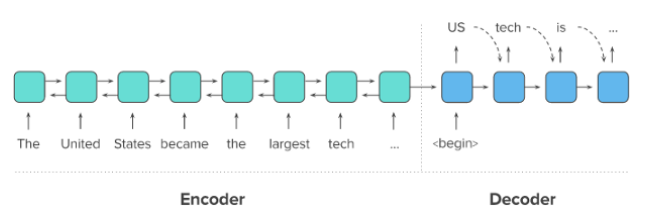

https://medium.com/dl-for-product-and-service/abstractive-text-summary-with-reinforcement-learning-ab2458ab29d5

## LSTM and context vector


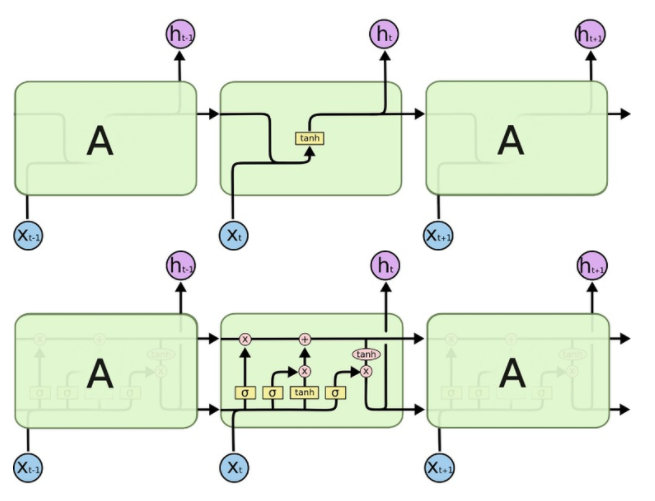

http://colah.github.io/posts/2015-08-Understanding-LSTMs

## start token and the end token

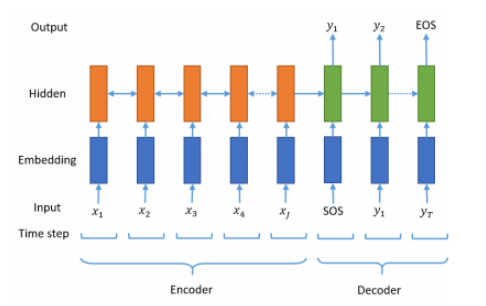

https://arxiv.org/pdf/1812.02303.pdf

## Attention mechanism that improves performance by actively utilizing information from the encoder rather than the existing context vector

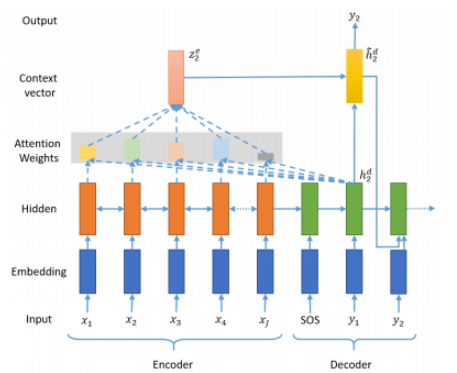

https://arxiv.org/pdf/1812.02303.pdf


# 1. Load the Data

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import urllib.request
import pandas as pd

urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
55369,77% voter turnout recorded in RK Nagar bypoll,The Election Commission on Thursday recorded a...
68999,States obligated to compensate cow vigilantism...,The Supreme Court on Friday said that all the ...
91841,United Airlines sued for forcing passenger to ...,United Airlines has been sued by a passenger c...
80600,US highway 'slimed' after truck carrying fish ...,"A highway in the US state of Oregon was ""slime..."
92968,Ultralight paper device can be charged with bo...,"Scientists have developed a lightweight, paper..."
87871,Researchers propose new type of planetary obje...,Scientists have suggested the existence of a p...
53840,"11,500-yr-old DNA reveals new population of Na...",Genetic analysis of a six-week-old infant that...
89657,Referee jokingly shows linesman red card for v...,Linesman Andrew McWilliam was jokingly shown a...
93447,Minister scolds principal over name on inaugur...,Minister in Punjab CM Amarinder Singh's Cabine...
86566,Amitabh shares pic on 44th marriage anniversar...,Actor Amitabh Bachchan shared a picture with w...


# 2. Data Preprocessing

In [4]:
print('Headline 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

Headline 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [5]:
data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


In [6]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [7]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


In [8]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [10]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (test)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [11]:
data.sample(1)
data['headlines'][0]

'upGrad learner switches to career in ML & Al with 90% salary hike'

In [12]:
from bs4 import BeautifulSoup
import re

clean_text = []

# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [13]:
clean_headlines = []

# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

clean_headlines[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [14]:
import numpy as np
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [15]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

Let's get train dataset and test dataset

and also draw graphs for text-length distribution

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534


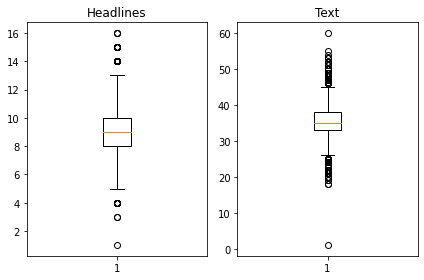

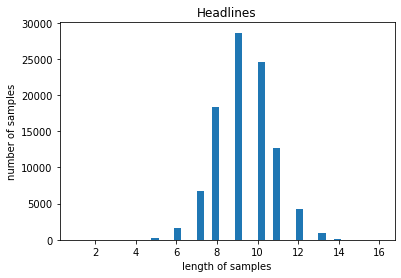

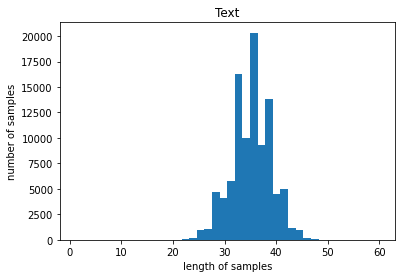

In [16]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('Headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()
# text 1~60
# headline 1~16

In [17]:
text_max_len = 40
headlines_max_len = 11

In [18]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [19]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9449877999186661


In [20]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 85843


In [21]:
#요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...


In [22]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [23]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[78567 27622 84570 ...  6622 34029 76480]


In [24]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [25]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 17168


In [26]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 68675
훈련 레이블의 개수 : 68675
테스트 데이터의 개수 : 17168
테스트 레이블의 개수 : 17168


# 3. Text -> Integer Encoding


In [27]:
from tensorflow.keras.preprocessing.text import Tokenizer 
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [28]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 64644
등장 빈도가 6번 이하인 희귀 단어의 수: 44052
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20592
단어 집합에서 희귀 단어의 비율: 68.1455355485428
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.7758593937104292


In [29]:
src_vocab = 20501
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [30]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[24, 1552, 6391, 11836, 157, 5997, 321, 4412, 15396, 154, 42, 406, 7072, 15396, 942, 21, 391, 2273, 13, 908, 3452, 13084, 16158, 1598, 19116, 2313, 8031, 13, 368, 194, 427], [244, 682, 377, 1321, 284, 242, 10544, 514, 7512, 244, 2065, 13610, 284, 1242, 4576, 281, 6477, 2447, 257, 377, 85, 448, 733, 140, 1, 487, 1171, 1107, 377, 1271, 821, 553, 13610], [1405, 978, 677, 152, 1866, 2351, 13085, 7287, 3129, 577, 677, 16, 77, 1888, 677, 345, 677, 272, 466, 917, 1866, 7288, 460, 1405, 6, 299, 2784, 97, 13085, 1926, 17971, 262, 12670, 1866, 792]]


In [31]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [32]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 28461
등장 빈도가 5번 이하인 희귀 단어의 수: 18747
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9714
단어 집합에서 희귀 단어의 비율: 65.86908400969747
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.1911460131170175


In [33]:
tar_vocab = 9744
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 38, 488, 6, 7577, 8879, 245], [1, 193, 1104, 264, 17, 5132, 1272, 10, 6285], [1, 1829, 121, 1947, 770, 3, 276], [1, 5360, 4757, 675, 779, 4124, 7578, 5133, 3, 846, 4, 24], [1, 60, 2513, 222, 132, 1248, 3, 82, 17, 637, 77, 528]]
target
decoder  [[38, 488, 6, 7577, 8879, 245, 2], [193, 1104, 264, 17, 5132, 1272, 10, 6285, 2], [1829, 121, 1947, 770, 3, 276, 2], [5360, 4757, 675, 779, 4124, 7578, 5133, 3, 846, 4, 24, 2], [60, 2513, 222, 132, 1248, 3, 82, 17, 637, 77, 528, 2]]


In [34]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 68674
훈련 레이블의 개수 : 68674
테스트 데이터의 개수 : 17168
테스트 레이블의 개수 : 17168


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [35]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headlines_max_len, padding='post')

# 4. Create Model


In [36]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.2, recurrent_dropout = 0.2)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.2, recurrent_dropout=0.2)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [37]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.2, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [38]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2624128     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

# 5. Attention Mechanism (Extractive summarization)



In [39]:
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [54]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [ ]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Not sure why it raises a TypeError (symbolic Keras i/o error), but let's keep move on to the next steps.

# 6. Train the Model


In [42]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 128, callbacks=[es], epochs = 50)

Epoch 1/50
537/537 [==============================] - 296s 531ms/step - loss: 5.9830 - val_loss: 5.6622
Epoch 2/50
537/537 [==============================] - 283s 527ms/step - loss: 5.5115 - val_loss: 5.2513
Epoch 3/50
537/537 [==============================] - 282s 524ms/step - loss: 5.1582 - val_loss: 4.9894
Epoch 4/50
537/537 [==============================] - 281s 524ms/step - loss: 4.9023 - val_loss: 4.8039
Epoch 5/50
537/537 [==============================] - 278s 518ms/step - loss: 4.7052 - val_loss: 4.6566
Epoch 6/50
537/537 [==============================] - 276s 514ms/step - loss: 4.5444 - val_loss: 4.5495
Epoch 7/50
537/537 [==============================] - 282s 525ms/step - loss: 4.4088 - val_loss: 4.4533
Epoch 8/50
537/537 [==============================] - 279s 520ms/step - loss: 4.2902 - val_loss: 4.3749
Epoch 9/50
537/537 [==============================] - 279s 520ms/step - loss: 4.1811 - val_loss: 4.3159
Epoch 10/50
537/537 [==============================] - 279s 520m

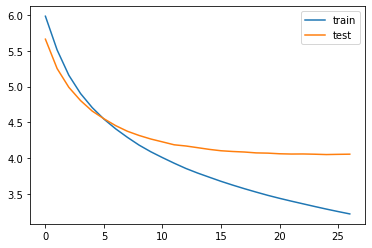

In [43]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# 7. Compare the Extractive / Abstractive summarization


Inference model

In [44]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [45]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [ ]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

The runtime crashed when I try to use `attn_layer`, but I had not enough time to find the root cause of this issue.

In [47]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

# 8. Test the Model

In [48]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [50]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : court arbitration sport thursday lifted life bans russians accused doping sochi winter olympics court thursday ruled insufficient evidence athletes benefited system state sponsored doping last winter games hosted russia 
실제 요약 : life bans on russians accused of doping lifted 


NameError: ignored

# 9. Summa Library
Since the above decoder is not working, I will try use `Summa`.   


In [2]:
!pip install summa

     |████████████████████████████████| 54 kB 1.7 MB/s 
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54410 sha256=58f891488721f6bf9187bb0f41b61a9c1ad74e7bbd31f486d045b7948cb0a9f2
  Stored in directory: /root/.cache/pip/wheels/29/64/ac/7b443477588d365ef37ada30d456bdf5f07dc5be9f6324cb6e
Successfully built summa


In [7]:
import requests
from summa.summarizer import summarize
import urllib.request
import pandas as pd

In [10]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data2 = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data2.head()


,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [13]:
for i in [0,1,2,3]:
    print("original:", data2['text'][i])
    print("\n healines:", data2['headlines'][i])
    print("\n summarise: ", summarize(data2['text'][i], ratio=0.35))

original: Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.

 healines: upGrad learner switches to career in ML & Al with 90% salary hike

 summarise:  upGrad's Online Power Learning has powered 3 lakh+ careers.
original: Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.

 healines: Delhi techie wins free food from Swiggy for one year on CRED

 summarise:  Users get one CRE

# Conclusion

- The runtime crashed when I try to use `attn_layer` and `decoder` so I could not see the result of the text_summarization, but I had not enough time to find the root cause of this issue.
- Try Extractive/Abstractive summarization
- Try various text normalizations that reduce the size of the vocabulary
- Apply Attention Mechanism that improves the performance of seq2seq
- Summarization result from `Summa` looks okay.